# Lab 3 - PID Control

# Objectives

The objectives of this lab are:
- Design a PID controller,
- Design a controller on a linearized plant, but investigate how it will operate on the nonlinear plant (i.e. investigate robustness).
- Investigate the magnitude of the input to the plant for different controllers

The plant in this lab is a pendulum attached to a motor as shown below.    

![pendulum](pendulum.png "pendulum")

The objective is to design a controller that will move the pendulum to a specific angle with minimal overshoot and ringing by applying a torque using the motor.

# Derivation of Plant Equations

The free body diagram for the system is shown below. 

![freeBodyDiagram](freeBodyDiagram.png "freeBodyDiagram")

In the free body diagram, $T_g$ is the torque due to gravity, and $T_m$ is the torque applied by the motor. 
The rotational inertia for a weight on the end of a massless rod is $J=mL^2$. Recall that torque is equal to force times the length of the lever. Therefore, in this case we have:
$$
\begin{align*}
    T_g(t)&=gmL \sin(\theta(t)), \\
    T_m (t)&=k_T i(t),
\end{align*}
$$
where 
-$i(t)$  is the current through the motor,
-$\theta(t)$ is the angle of the pendulum (where $\theta=0$ is pointing downwards),
-$k_T$ is the usual torque constant,
-$m$ is the mass of the weight at the end of the pendulum,
-$L$ is the length of the pendulum,
-$g$ is the gravitational constant ($9.81m/s^2$).

Summing the torques we get the expression:
$$
\begin{align*} 
T_m - T_g &= J \alpha   \\
k_T i(t) - gmL\sin(\theta(t)) &= mL^2 \frac{d^2 \theta}{dt^2}
\end{align*}
$$
Note that this is a nonlinear differential equation. Why? 

When the pendulum is in the downward vertical position, the angle is $0$. Let us linearize the system around this point. If $\theta$ is close to zero, then
$$
\begin{align*}
\sin(\theta)\approx \theta. 
\end{align*}
$$

Plug this into the differential equation:
$$
\begin{align*} 
    k_T i(t) - gmL\theta(t) &= mL^2 \frac{d^2 \theta}{dt^2}
\end{align*}
$$
which is an ordinary (linear) differential equation. 

Taking the Laplace Transform of both sides we end up with the following transfer function:
$$
\begin{align*}
    \frac{\theta(s)}{I(s)} = \frac{k_T}{mL^2s^2+gmL}
\end{align*}
$$

The values for $k_T$, $m$, $g$ and $L$ are:
- $k_T = 1$
- $m = \frac{1}{0.981^2}$,
- $g = 9.81$,
- $L = 0.981$,


# Objective of the controller

The control objectives are to design a controller that is fast enough so that the pendulum can be balanced upside down. We will be designing the controller based on a linearized approximation of the nonlinear differential equations governing the pendulum. In addition we will be imposing a limit as to how much current the current source can supply. We will test our final control design on the nonlinear system. 

# Part 1 - Robustness

In this section we will design a PID controller and look at its robustness. 

# Question 1

Design a PID controller such that the $2$ % settling time of the closed loop system is around $0.5s$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import control as ct
import enel441_utilities as eu

Plant transfer function:

   1
--------
s^2 + 10



Text(0.5, 23.52222222222222, 'Time (s)')

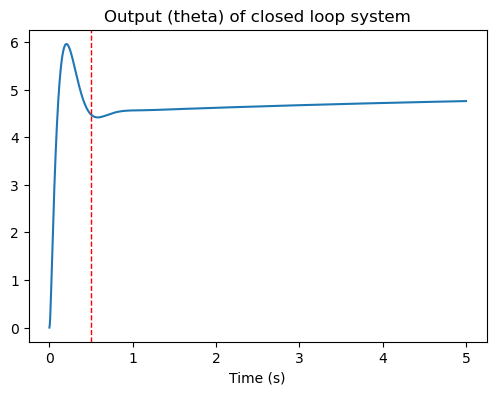

In [24]:
kT = 1
m = 1/0.981**2
g = 9.81
L = 0.981
P = ct.tf(kT/L**2/m, [1, 0, g/L])

print('Plant transfer function:')
print(P)

# Choose values for Kp, Kd, and Ki
Kp =  90     
Kd =  12
Ki =  15

K_pid1 = ct.tf([(Kd+0.01*Kp), (Kp+0.01*Ki), Ki], [0.01, 1, 0])

T1 = P*K_pid1/(1+P*K_pid1)
S1 = 1/(1+P*K_pid1)

t = np.linspace(0,5,1000)
r = 5*np.pi/180 * np.ones(t.shape)
t,y_lin1 = ct.forced_response(T1,t,r)
t,u_lin1 = ct.forced_response(K_pid1*S1,t,r)

fig, ax = plt.subplots(1)
fig.tight_layout(pad=5.0)
ax.plot(t,y_lin1*180/np.pi)
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=1)
ax.set_title('Output (theta) of closed loop system')
ax.set_xlabel('Time (s)')

# Question 3

Make plots of the Sensitivity, Complementary Sensitivity, $K S$ and $P S$ for the PID controller that you designed. What can you say about the robustness of your design?

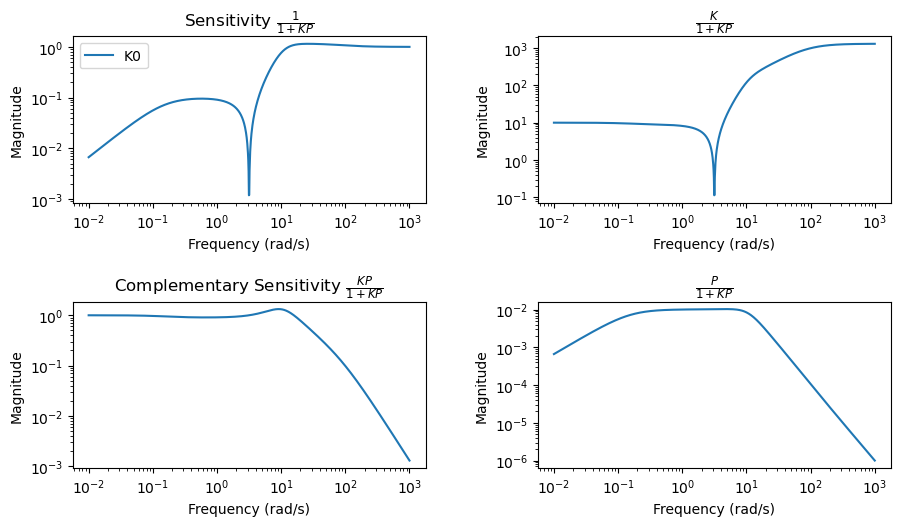

In [25]:
fig, ax = eu.plot_gang_of_four(P,[K_pid1])

# Question 4

You have designed the controller on a linearized approximation of the pendulum. Let's try to use the controller on the original (nonlinear) equations. Use the following code to run a simulation using the nonlinear equations of the pendulum system. 

Does the PID controller still work? Why or why not? 

Start with a reference signal (desired output) that is a step of 5 degrees. Increase the desired final position of the 
pendulum until you see a large difference between the linearized model and the nonlinear model. Try angles between 0 and 180 degrees.

What is the angle where you start to see significant difference between the outputs?

Is the controller stable for all reference signals applied (with desired positions between $0$ and $180$ degrees)?

In [26]:
# Some functions to run a simulation of the nonlinear system

def pendulum_update(t, x, u, params={}): 
    m = params.get('m', 1/0.981**2)
    g = params.get('g', 9.81)
    L = params.get('L', 0.981)
    max_Torque = params.get('max_Torque', 100)

    theta_pend = x[0]  
    dtheta_pend = x[1]

    #torque_applied = np.clip(u[0], -max_Torque, max_Torque)  
    torque_applied = u[0]
    J = m*L**2
    ddtheta_pend = torque_applied/J - L*m*g/J*np.sin(theta_pend)
    dx = np.array([dtheta_pend, ddtheta_pend])
    return dx

def pendulum_out(t,x,u,params={}):
    return x[0]
    
def simulate_closed_loop_pendulum(K,t,r,x0):
    pendulum = ct.NonlinearIOSystem(
        pendulum_update, pendulum_out, name='pendulum',
        inputs=('Tm'), outputs=('theta'), states=('theta', 'dtheta'))
    controller = ct.tf2io(K,name='controller', inputs='u', outputs='y')

    closed_loop_system = ct.InterconnectedSystem(
        (controller, pendulum), name='pendulum',
        connections=(
            ['controller.u', '-pendulum.theta'],
            ['pendulum.Tm', 'controller.y']),
        inplist=('controller.u'),
        inputs=('ref'),
        outlist=('pendulum.theta', 'controller.y'),
        outputs=('theta', 'Tm'))

    t, y_nonlin = ct.input_output_response(
            closed_loop_system, t, r, x0)
    return t,y_nonlin

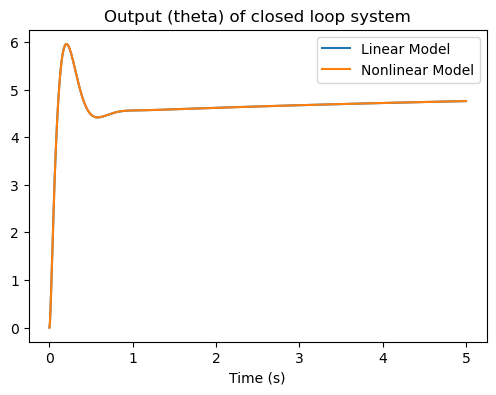

In [27]:
t = np.linspace(0,5,1000)

# This is the reference signal, change the value of the desired final position
r = 5*np.pi/180 * np.ones(t.shape)

t,y_lin1 = ct.forced_response(T1,t,r)

x0 = np.array([0,0])
t,y_nonlin1 = simulate_closed_loop_pendulum(K_pid1,t,r,x0)

fig, ax = plt.subplots(1)
fig.tight_layout(pad=5.0)
ax.plot(t,y_lin1*180/np.pi, label='Linear Model')
ax.plot(t,y_nonlin1[0]*180/np.pi, label='Nonlinear Model')
ax.set_title('Output (theta) of closed loop system')
ax.set_xlabel('Time (s)')
ax.legend()




# Part 2 - Input Applied to the Plant

Another key difference between simulating a control system and implementing a control system on a physical system is that in simulation any input can be applied to the plant, whereas in practice the input that can be applied is bounded by physical constraints. 

For example, in this system, the input applied to the motor may be bounded by $\pm$ 2 amps.

In the code below a new simulator is implemented that does not allow more that $2$ amps to be applied to the motor. 

How significant is the change in the output for your controller?


In [28]:
# Some functions to run a simulation of the nonlinear system

def pendulum_update_with_saturation(t, x, u, params={}): 
    m = params.get('m', 1/0.981**2)
    g = params.get('g', 9.81)
    L = params.get('L', 0.981)
    max_Torque = params.get('max_Torque', 2)

    theta_pend = x[0]  
    dtheta_pend = x[1]

    torque_applied = np.clip(u[0], -max_Torque, max_Torque)  
    J = m*L**2
    ddtheta_pend = torque_applied/J - L*m*g/J*np.sin(theta_pend)
    dx = np.array([dtheta_pend, ddtheta_pend])
    return dx

def pendulum_out(t,x,u,params={}):
    return x[0]
    
def simulate_closed_loop_pendulum_with_saturation(K,t,r,x0):
    pendulum = ct.NonlinearIOSystem(
        pendulum_update_with_saturation, pendulum_out, name='pendulum',
        inputs=('Tm'), outputs=('theta'), states=('theta', 'dtheta'))
    controller = ct.tf2io(K,name='controller', inputs='u', outputs='y')

    closed_loop_system = ct.InterconnectedSystem(
        (controller, pendulum), name='pendulum',
        connections=(
            ['controller.u', '-pendulum.theta'],
            ['pendulum.Tm', 'controller.y']),
        inplist=('controller.u'),
        inputs=('ref'),
        outlist=('pendulum.theta', 'controller.y'),
        outputs=('theta', 'Tm'))

    t, y_nonlin = ct.input_output_response(
            closed_loop_system, t, r, x0)
    return t,y_nonlin

In [29]:
x0 = np.array([0,0])
t = np.linspace(0,5,1000)
r = 5*np.pi/180 * np.ones(t.shape)
t,y_nonlin1 = simulate_closed_loop_pendulum(K_pid1,t,r,x0)
t,y_nonlin2 = simulate_closed_loop_pendulum_with_saturation(K_pid1,t,r,x0)

Text(0.5, 58.7222222222222, 'Time (s)')

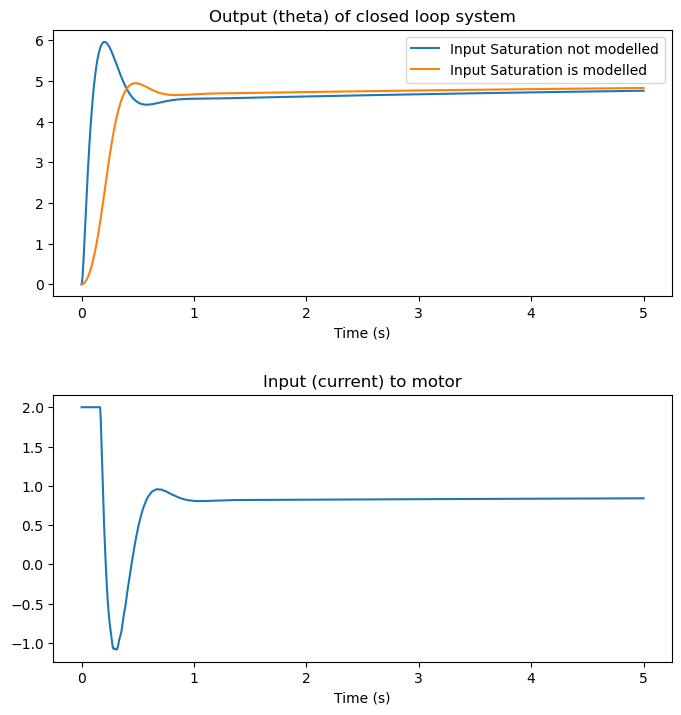

In [30]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
fig.tight_layout(pad=5.0)
ax[0].plot(t,y_nonlin1[0]*180/np.pi, label='Input Saturation not modelled')
ax[0].plot(t,y_nonlin2[0]*180/np.pi, label='Input Saturation is modelled')
ax[0].set_title('Output (theta) of closed loop system')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

#ax[1].plot(t,y_nonlin1[1])
ax[1].plot(t,np.clip(y_nonlin2[1],-2,2))
ax[1].set_title('Input (current) to motor')
ax[1].set_xlabel('Time (s)')

# Question 5

Redesign the PID controller to reduce the magnitude of the input that must be applied to the plant. Design a PID controller such that:
- the input is only being saturated for $0.25s$ or less, and
- the $2$ % settling time is (approximately) less than $1s$.

Text(0.5, 58.7222222222222, 'Time (s)')

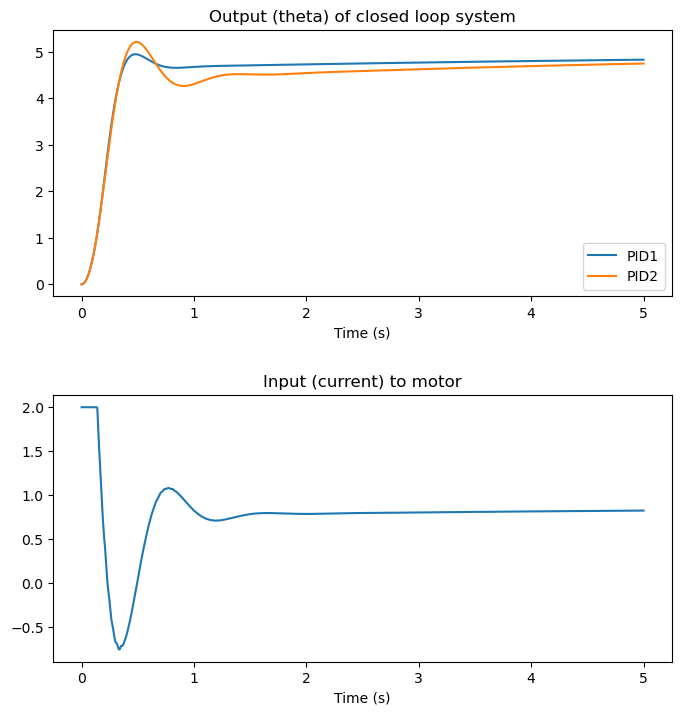

In [31]:
# Choose values for Kp, Kd and Ki
Kp =  53        
Kd =  7
Ki = 12

K_pid2 = ct.tf([(Kd+0.01*Kp), (Kp+0.01*Ki), Ki], [0.01, 1, 0])

x0 = np.array([0,0])
t = np.linspace(0,5,1000)
r = 5*np.pi/180 * np.ones(t.shape)
t,y_nonlin1 = simulate_closed_loop_pendulum_with_saturation(K_pid1,t,r,x0)
t,y_nonlin2 = simulate_closed_loop_pendulum_with_saturation(K_pid2,t,r,x0)

fig, ax = plt.subplots(2,1, figsize=(8,8))
fig.tight_layout(pad=5.0)
ax[0].plot(t,y_nonlin1[0]*180/np.pi, label='PID1')
ax[0].plot(t,y_nonlin2[0]*180/np.pi, label='PID2')
ax[0].set_title('Output (theta) of closed loop system')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

#ax[1].plot(t,y_nonlin1[1])
ax[1].plot(t,np.clip(y_nonlin2[1],-2,2))
ax[1].set_title('Input (current) to motor')
ax[1].set_xlabel('Time (s)')



# Question 6

Make plots of the Sensitivity, Complementary Sensitivity, $K S$ and $P S$ for both PID controllers that you designed. What can you say magnitude of the input required for both these systems? 

How else do the designs differ?

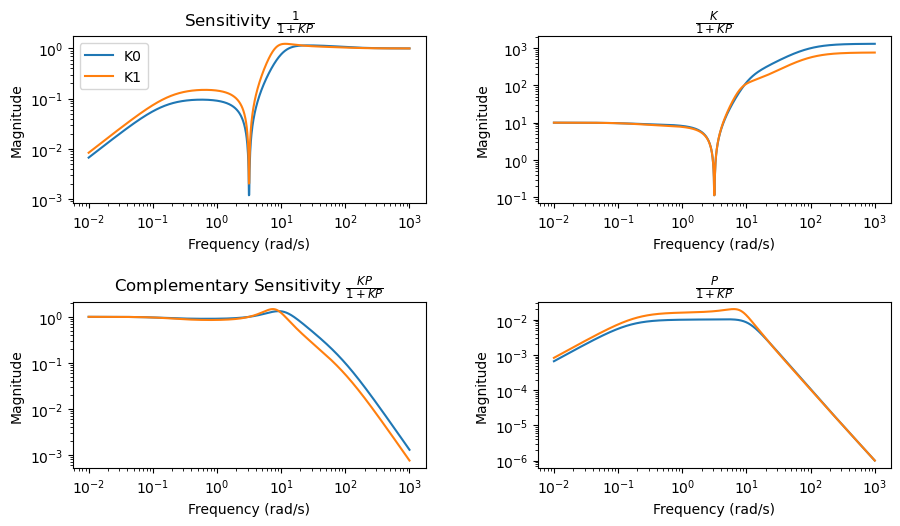

In [32]:
fig, ax = eu.plot_gang_of_four(P,[K_pid1, K_pid2])

# Question 7

See if either of your designs are able to swing the pendulum upside down and keep it at 180 degrees. Use the code below.

Text(0.5, 0, 'Time (s)')

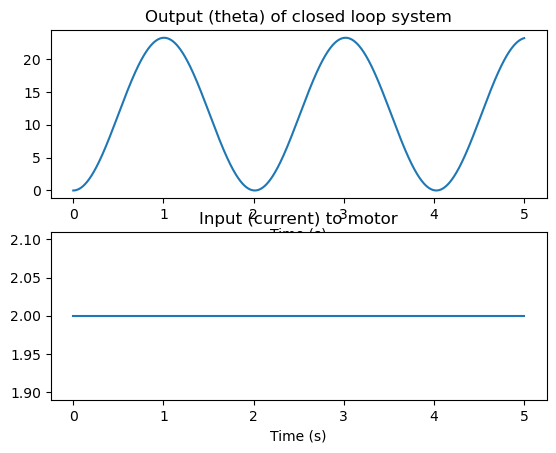

In [33]:
x0 = np.array([0,0])
r = 180*np.pi/180 * np.ones(t.shape)
t,y_nonlin_180 = simulate_closed_loop_pendulum_with_saturation(K_pid2,t,r,x0)
fig,ax = plt.subplots(2,1)
ax[0].plot(t,y_nonlin_180[0]*180/np.pi)
ax[0].set_title('Output (theta) of closed loop system')
ax[0].set_xlabel('Time (s)')

ax[1].plot(t,np.clip(y_nonlin_180[1],-2,2))
ax[1].set_title('Input (current) to motor')
ax[1].set_xlabel('Time (s)')

# End of Lab